### Monte Carlo Project##

*Title: 2D Ostwald Ripening simulation*

This is a phenomenon observed in solid solutions and liquid solutions where the grain size distribution of the solute narrows down. This occurs when grains of a certain critical size starts growing while grains below the critical size starts dissolving into the solution and redeposits on the larger grains. This technique allows the growth of crystals with a homogenous size distribution. 

Question that can be answered:

* Is the domain size (R) a function of time and agrees with R(t) ~ t^{1/3}?
* What is the critical radius for point particles and for an x shaped molecule?

Approach towards problem:

* Consider an alloy with two phases where the phenomenon is expected to be observed.
* The Ising model has been known to model ferromagnetic behaviour of materials primarily. But this model has also applications in phase seperation of alloys.
* The phase seperation problem in alloys can first be studied using the Ising model before approaching the Oswald ripening problem since this the phase seperation problem can directly use the Ising model.


#### Ising model for phase seperation ###

Psuedo code (particle based model)

* Intialize an mxn lattice with random distribution of particle(1) and matrix(-1).
* Randomly pick two positions on the lattice and switch them.
* Calculate energy
* Calculate change in energy and acceptance probability

Here energy is calculated using 

$$ E = -J \sum_{i,j}{s_is_j} $$

Where J is the interaction energy (assumed a value of 1 as of now for all particles-particle interactions) and the sum represents sum over all the 4 nearest neighbours in the 2D lattice.


In [21]:
%matplotlib inline
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def energy(system,j=1):
    e = 0
    m = len(system) # rows
    n = len(system[0]) # columns
    for x in range(m):
        for y in range(n):
            s = system[x,y] # get the spin at current location
            e += -j*(s*(system[(x-1)%m,y]+system[(x+1)%m,y]+system[x,(y-1)%n]+system[x,(y+1)%n])) # -j*sum(s_i*s_j)       
    return e

def trial_move(s): #randomly swap two positions in the system
    temp = np.copy(s) # copy system
    m = len(temp) # row
    n = len(temp[0]) # column
    x1 = np.random.randint(0, m) # get random position1 x coordinate
    y1 = np.random.randint(0, n) # get random position1 y coordinate
    x2 = np.random.randint(0, m) # get random position2 x coordinate
    y2 = np.random.randint(0, n) # get random position2 y coordinate
    temp[x2,y2], temp[x1,y1] = temp[x1,y1],temp[x2,y2]
    return temp

def accept(de,kT): #implement detailed balance
    if np.exp(-de/kT) > np.random.rand():
        return True
    return False
        
def initialCondition(m,n):
    system = 2*np.random.randint(2, size=(m,n))-1    
    return system
            
def run(kT,steps,systemSize=10,j=1): #specify temperature, number of steps to perform simulation
    system = initialCondition(systemSize,systemSize) #initialize 1's  and -1's randomly as it would at a high temperature
    e = np.array( int(steps)*[0])  #store energies in here
    for trials in range(int(steps)):
        trial = trial_move(system)
        de = energy(trial,j)-energy(system,j)
        if accept(de,kT):
            system = np.copy(trial)
        e[trials] = energy(system)
    return kT,e.mean(), e.std(), system #Return the temperature, average energy, and standard deviation

def plotAvgEnergyWrtTrials(kT,timeSteps,systemSize=10,j=1): #specify temperature, number of steps to perform simulation
    system = initialCondition(systemSize,systemSize) #initialize 1's  and -1's randomly as it would at a high temperature
    #plt.pcolormesh(range(systemSize), range(systemSize), system, cmap=plt.cm.gray);
    avgE = []
    stdDE = []
    ts=[]
    steps = timeSteps[-1]

    e = []
    ims = []
    fig = plt.figure(0)
    ax=fig.add_subplot(1,1,1)  
    ax.set_title("Timestep= {}".format(0))
    im = plt.imshow(system, animated=True, axes=ax)
    ims.append([im])
    
    for ntrial in range(1,int(steps)+1):
        trial = trial_move(system)
        de = energy(trial,j)-energy(system,j)
        if accept(de,kT):
            system = np.copy(trial)
        #e[ntrial] = energy(system)
        #print("ntrial:{}".format(ntrial))
        e.append(energy(system))
        #print("system:\n {}".format(system))
        #print("e: {}".format(e))
        #print("e-mean: {} e-stddev: {}".format(np.mean(e),np.std(e)))
        if(ntrial in timeSteps.astype(int)):
            avgE.append(np.mean(e))
            stdDE.append(np.std(e)) 
            ts.append(ntrial)
            ax.set_title("Timestep= {}".format(ntrial))
            im = plt.imshow(system, animated=True,axes=ax, rasterized=True)#,cmap='gist_gray_r')
            ims.append([im])
        
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    ani.save('variedTrials.mp4')
        
    plt.figure(1)
    plt.xlabel("Trials")
    plt.ylabel("Energy")
    plt.xscale('log')
    plt.errorbar(ts,avgE,stdDE,linestyle='--', marker='o', color='b')
    plt.figure(2)
    plt.xlabel("Trials")
    plt.ylabel("Standard Deviation [Energy units]")
    plt.xscale('log')
    plt.plot(ts,stdDE,linestyle='--', marker='o', color='b')

    return kT #Return the temperature

def plotAvgEnergyWrtEnergies(kTs,trialsToEquil,systemSize=10,j=1): #specify temperature, number of steps to perform simulation
    system = initialCondition(systemSize,systemSize) #initialize 1's  and -1's randomly as it would at a high temperature
    #plt.pcolormesh(range(systemSize), range(systemSize), system, cmap=plt.cm.gray);
    avgE = []
    stdDE = []
    temps=[]
    
    ims = []
    fig = plt.figure(0)
    ax=fig.add_subplot(1,1,1)  
    ax.set_title("Timestep= {}".format(0))
    im = plt.imshow(system, animated=True, axes=ax)
    ims.append([im])
    for kT in kTs:
        np.random.seed(1234567)
        e = []
        print('Temperature: {}'.format(kT))
        for ntrial in range(1,int(trialsToEquil)):
            trial = trial_move(system)
            de = energy(trial,j)-energy(system,j)
            if accept(de,kT):
                system = np.copy(trial)
            e.append(energy(system))
    
        ax.set_title("Energy= {}".format(kT))
        im = plt.imshow(system, animated=True,axes=ax, rasterized=True)#,cmap='gist_gray_r')
        ims.append([im])
        
        avgE.append(np.mean(e))
        stdDE.append(np.std(e)) 
        temps.append(kT)
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    ani.save('variedEnergies.mp4')
        
    plt.figure(1)
    plt.xlabel("Energy [kT]")
    plt.ylabel("Average System Energy")
    plt.errorbar(temps,avgE,stdDE,linestyle='--', marker='o', color='b')
    
    return kT #Return the temperature

### We can start with a small system (4x4) and calculate the number of trials to equilibriate the system. Also keping the temperature very low @ 1e-3 (kT) ### 

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:28: RuntimeWarning: overflow encountered in exp


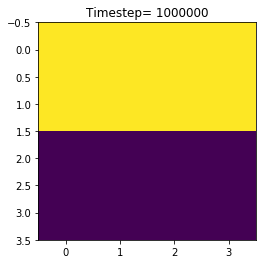

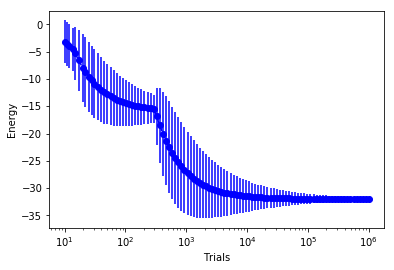

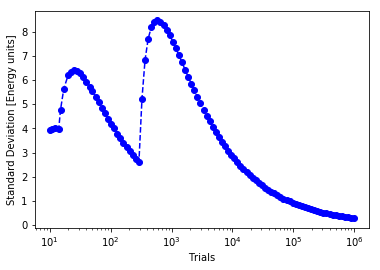

In [22]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeSteps = np.logspace(1,6,100)
kT = 1e-3 # a very low temerature

systemSize=4
np.random.seed(1234567)
t = plotAvgEnergyWrtTrials(kT,timeSteps,systemSize)

video = io.open('variedTrials.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

### So it apears that for a 4x4 system, 1e5 trials are enough to equilibriate the system. At 1e-3 kT, the average energy of the system appears to be ~ -30. Now calculating average energy at a high temperature of 100 kT###

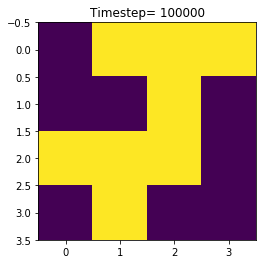

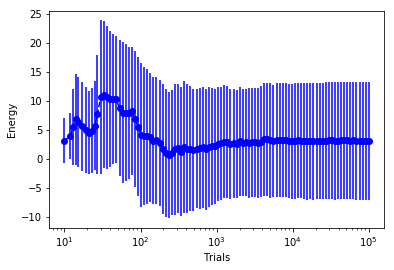

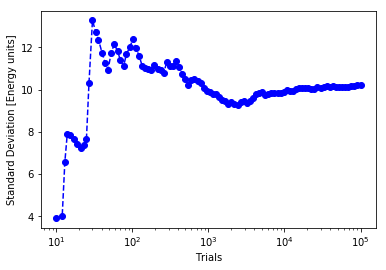

In [15]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeSteps = np.logspace(1,5,100)
kT = 1e2 # a very high temerature

systemSize=4
np.random.seed(1234567)
t = plotAvgEnergyWrtTrials(kT,timeSteps,systemSize)

video = io.open('variedTrials.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

### So it appears that the average energy at a high temperature of 100 kT is ~ 3 [energy units]. Is there a temperature at which the energy drops suddenly as seen in previous homework? Trying to calculate the average energy over a range 1e-3 - 100###

[  1.00000000e+02   9.47368947e+01   8.94737895e+01   8.42106842e+01
   7.89475789e+01   7.36844737e+01   6.84213684e+01   6.31582632e+01
   5.78951579e+01   5.26320526e+01   4.73689474e+01   4.21058421e+01
   3.68427368e+01   3.15796316e+01   2.63165263e+01   2.10534211e+01
   1.57903158e+01   1.05272105e+01   5.26410526e+00   1.00000000e-03]
Temperature: 100.0
Temperature: 94.7368947368421
Temperature: 89.4737894736842
Temperature: 84.21068421052632
Temperature: 78.94757894736843
Temperature: 73.68447368421053
Temperature: 68.42136842105263
Temperature: 63.158263157894744
Temperature: 57.89515789473685
Temperature: 52.63205263157895
Temperature: 47.36894736842106
Temperature: 42.105842105263164
Temperature: 36.84273684210527
Temperature: 31.57963157894737
Temperature: 26.31652631578949
Temperature: 21.05342105263159
Temperature: 15.790315789473695
Temperature: 10.527210526315798
Temperature: 5.2641052631579015
Temperature: 0.001


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:28: RuntimeWarning: overflow encountered in exp


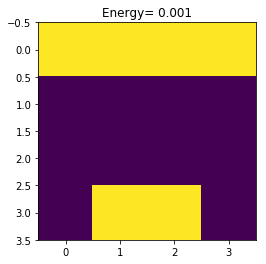

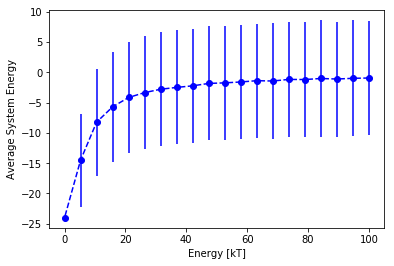

In [23]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeStepsToEquil = 1e5
kTs = np.linspace(100,1e-3,20)
print(kTs)
systemSize=4

t = plotAvgEnergyWrtEnergies(kTs,timeStepsToEquil,systemSize)

video = io.open('variedEnergies.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

### So there appears to be transition temperature, but needs more resolution to see the transition clearly ##

[  1.00000000e+02   5.45559478e+01   2.97635144e+01   1.62377674e+01
   8.85866790e+00   4.83293024e+00   2.63665090e+00   1.43844989e+00
   7.84759970e-01   4.28133240e-01   2.33572147e-01   1.27427499e-01
   6.95192796e-02   3.79269019e-02   2.06913808e-02   1.12883789e-02
   6.15848211e-03   3.35981829e-03   1.83298071e-03   1.00000000e-03]
Temperature: 100.0
Temperature: 54.5559478116852
Temperature: 29.763514416313193
Temperature: 16.237767391887218
Temperature: 8.858667904100827
Temperature: 4.8329302385717545
Temperature: 2.636650898730358
Temperature: 1.438449888287663
Temperature: 0.7847599703514615
Temperature: 0.4281332398719396
Temperature: 0.23357214690901237
Temperature: 0.12742749857031346
Temperature: 0.06951927961775606
Temperature: 0.0379269019073225
Temperature: 0.0206913808111479
Temperature: 0.011288378916846895
Temperature: 0.006158482110660267
Temperature: 0.003359818286283781
Temperature: 0.0018329807108324375
Temperature: 0.001


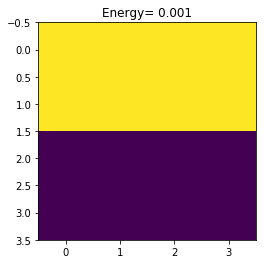

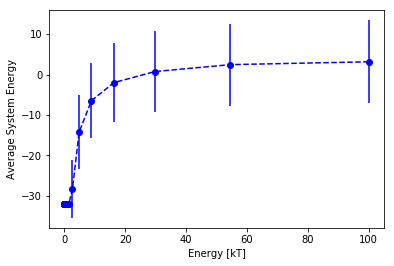

In [25]:
import numpy as np
import io
import base64
from IPython.display import HTML

timeStepsToEquil = 1e5
kTs = np.logspace(2,-3,20)
print(kTs)
systemSize=4

t = plotAvgEnergyWrtEnergies(kTs,timeStepsToEquil,systemSize)

video = io.open('variedEnergies.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

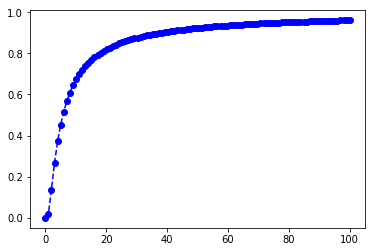

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0.00001,100,100)

y = np.exp(-4./x)

plt.plot(x,y,linestyle='--', marker='o', color='b')